# This project will conduct some basic analysis on vehicles in the US.

### First we will upload some of the libraries that we need to conduct our analysis.
We will need to add them to our interperter, I will be using anaconda and it's base version since it has most of the packages we need installed already. We will need to install altair, streamlit, plotly, seaborn. If you want we can also do matplotlib as an alternative for our plots. If you need an enviornment to use I created one name proj_env and it is in the files associated with the project under environment.yml you can see what is installed with it. 

In [306]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import streamlit as st
import plotly.express as px
#we may not need all of these as plotly.express is for graphing and so is matplotlib so either one is good for preference



Next we are going to read the csv file we want to investigate. In this case vehicles_us.csv, then print the first couple of lines.

In [307]:
df= pd.read_csv('/Users/12629/tripleten_project/tripleten_project/vehicles_us.csv')
df.head()

price  model_year           model  condition  cylinders fuel  odometer  \
0   9400      2011.0          bmw x5       good        6.0  gas  145000.0   
1  25500         NaN      ford f-150       good        6.0  gas   88705.0   
2   5500      2013.0  hyundai sonata   like new        4.0  gas  110000.0   
3   1500      2003.0      ford f-150       fair        8.0  gas       NaN   
4  14900      2017.0    chrysler 200  excellent        4.0  gas   80903.0   

  transmission    type paint_color  is_4wd date_posted  days_listed  
0    automatic     SUV         NaN     1.0  2018-06-23           19  
1    automatic  pickup       white     1.0  2018-10-19           50  
2    automatic   sedan         red     NaN  2019-02-07           79  
3    automatic  pickup         NaN     NaN  2019-03-22            9  
4    automatic   sedan       black     NaN  2019-04-02           28

Firstly, we can see that the data is being loaded in correctly and we do not need to adjust reading the files with any arguements. Next we need to find how many missing or duplicate values we have. We will do this with .info() and .describe().

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [309]:
df.describe()

price    model_year     cylinders       odometer   is_4wd  \
count   51525.000000  47906.000000  46265.000000   43633.000000  25572.0   
mean    12132.464920   2009.750470      6.125235  115553.461738      1.0   
std     10040.803015      6.282065      1.660360   65094.611341      0.0   
min         1.000000   1908.000000      3.000000       0.000000      1.0   
25%      5000.000000   2006.000000      4.000000   70000.000000      1.0   
50%      9000.000000   2011.000000      6.000000  113000.000000      1.0   
75%     16839.000000   2014.000000      8.000000  155000.000000      1.0   
max    375000.000000   2019.000000     12.000000  990000.000000      1.0   

       days_listed  
count  51525.00000  
mean      39.55476  
std       28.20427  
min        0.00000  
25%       19.00000  
50%       33.00000  
75%       53.00000  
max      271.00000

Looks like we have some some missing values in the model_year, cylinders, odometer, paint_color, and is_4wd. Lets address those columns.

In [310]:
df['model_year'].isnull().sum()

3619

In [311]:
df['model_year'].value_counts(dropna=False)

model_year
NaN       3619
2013.0    3549
2012.0    3468
2014.0    3448
2011.0    3375
          ... 
1948.0       1
1961.0       1
1936.0       1
1949.0       1
1929.0       1
Name: count, Length: 69, dtype: int64

Okay we want to deal with the missing values. Since the dtypes for model_year is float we should try to keep that consistant so we will change our NaN values with the median value so that it is less likely to influence our data if we run any statisics on it. We will also groupby the model to help spread out the data and keep it evenly distributed.

In [312]:
df['model_year'] = df['model_year'].fillna(df.groupby(['model'])['model_year'].transform('median'))

df['model_year'].isnull().sum()

0

In [313]:
df['model_year'].head()

0    2011.0
1    2011.0
2    2013.0
3    2003.0
4    2017.0
Name: model_year, dtype: float64

Next we will work on cylinders. In this case we will group the NaN values by the model and the transmission to help evenly distribute the data as these columns are closely related to what cylinders a vehicle will have. 

In [314]:
df['cylinders'].value_counts(dropna=False)

cylinders
8.0     15844
6.0     15700
4.0     13864
NaN      5260
10.0      549
5.0       272
3.0        34
12.0        2
Name: count, dtype: int64

In [315]:
df['cylinders']= df['cylinders'].fillna(df.groupby(['model', 'transmission'])['cylinders'].transform('median')) 
#if we leave with just this groupby we are left with 1 null value and so we will fill that with the median
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())

df['cylinders'].isnull().sum()



0

In [316]:
df['cylinders'].head()

0    6.0
1    6.0
2    4.0
3    8.0
4    4.0
Name: cylinders, dtype: float64

We will do the odometer next. This one we will use model and model year to groupby as this will make it so we are working with different usage patterns like a truck may have more miles than a mini coup. And model year as older vehicles will likely have more miles. 

In [317]:
df['odometer']= df['odometer'].fillna(df.groupby(['model', 'model_year'])['odometer'].transform('median'))
df['odometer'].isnull().sum()

83

Next we will do paint_color. This time we will do unknown for the replacement as it will be it's own category in the object dtype.

In [318]:
df['paint_color']= df['paint_color'].fillna('unknown')
df['paint_color'].isnull().sum()

0

For is_4w we will make the NaN a 0 so that it is easy to see that the car is either 1= 4w or 0= not 4w or is unknown.

In [319]:
df['is_4wd']= df['is_4wd'].fillna(0)
df['is_4wd'].isnull().sum()

0

Now we will check .info() to see if everything is cleared up and still has the same dtype.

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     51525 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      51442 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   51525 non-null  object 
 10  is_4wd        51525 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


Now that the data is set for further anaylisis in terms of filled data we need to check for any duplicates.

In [321]:
df.duplicated().sum()

0

Well that makes it easy for us. Now we can move on to the next part. We will also push everything we have to git quick to keep it updated.
Now we are going to look at the price distribution, plot the state of condition graph that looks at the different conditions of the vehichles, condition vs price graph, 4wd vs non-4wd and price, lastly we will look at odometer vs price.

First we will do a basic price distribution to see how the price varies.

In [322]:
price_counts = df['price'].value_counts().reset_index()
price_counts.columns = ['price', 'count']

fig = px.scatter(price_counts, x='price', y='count', 
                 title='Price Distribution', 
                 labels={'price': 'Price', 'count': 'Frequency'},
                 color='count', 
                 color_continuous_scale='Viridis')

fig.update_layout(
    xaxis_title="Price",
    yaxis_title="Car Count",
    showlegend=False
)

fig.show()


This is hard to read so lets make a box chart of it to get a better idea of what the data is telling us.

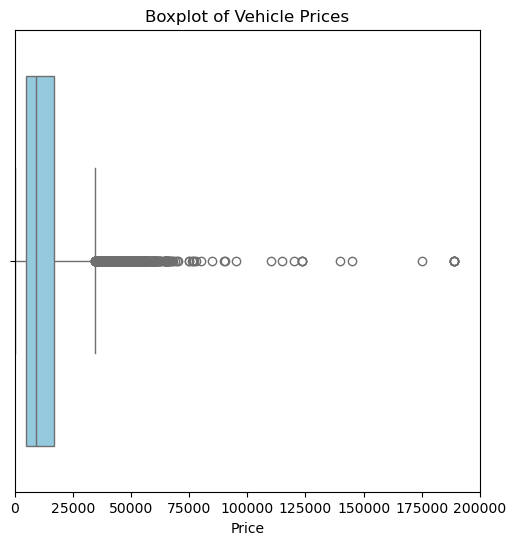

In [323]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='price', color='skyblue')
plt.title('Boxplot of Vehicle Prices')
plt.xlabel('Price')
plt.xlim(0,200000)
plt.show()


In [324]:
df['price'].describe()

count     51525.000000
mean      12132.464920
std       10040.803015
min           1.000000
25%        5000.000000
50%        9000.000000
75%       16839.000000
max      375000.000000
Name: price, dtype: float64

From these two plots we can see that the pricing varies a lot and we can look into why that is. But to interpret this data we can see that the median is only 9000 dollars, but that most of the vehichles tend to be at that point. We can see that the data is skewed to the right or high as the mean is much higher than the median and that we have several outliers higher than the median and its statistical range. This indicates that there are probably many factors as to why the price of a vehicle fluxuates. Lets look at the conditions of the vehicles and then after compare them to the price. Note that there were outliers that went beyond our scale and was causing the graphs to look unreadable so we scaled the graphs to have a limit up to 200,000. We already know from looking at the histogram and the describe() that the max goes up to 375,000.

Let us take a look at just the conditions of the vehicles and see what we are working with.

In [325]:
df['condition'].value_counts()

condition
excellent    24773
good         20145
like new      4742
fair          1607
new            143
salvage        115
Name: count, dtype: int64

In [326]:
condition_order = ['salvage', 'new', 'fair', 'like new', 'good', 'excellent']
cond_car = px.histogram(df, x='condition', 
                   title='Distribution of Vehicle Condition', 
                   color='condition', 
                   category_orders={'condition': condition_order}
                   )
cond_car.show()





Looks like we have more cars that in better conditions rather than poor i.e salvage and fair vs new, like new, etc. This already indicates that there is more of a market in those type of vehicles and that demand is higher for good like conditioned vehicles. Now we are going to see the relationship between the price and the condition.

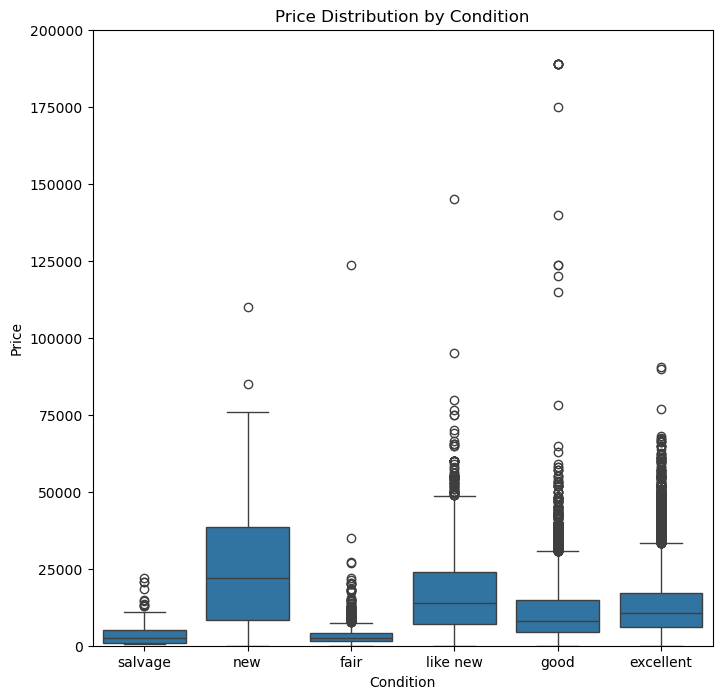

In [327]:
plt.figure(figsize=(8,8))
sns.boxplot(data=df, x='condition', y='price', order= condition_order)
plt.title('Price Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.ylim(0,200000)

plt.show()

In [328]:
df[df['condition']=='salvage']['price'].describe()

count      115.000000
mean      4242.295652
std       4686.620046
min        400.000000
25%       1000.000000
50%       2500.000000
75%       5100.000000
max      22000.000000
Name: price, dtype: float64

In [329]:
df[df['condition']=='new']['price'].describe()

count       143.000000
mean      26050.300699
std       21028.831965
min           1.000000
25%        8300.000000
50%       21999.000000
75%       38607.000000
max      109999.000000
Name: price, dtype: float64

In [330]:
df[df['condition']=='fair']['price'].describe()

count      1607.000000
mean       3386.502178
std        4308.814660
min           1.000000
25%        1500.000000
50%        2500.000000
75%        4000.000000
max      123456.000000
Name: price, dtype: float64

In [331]:
df[df['condition']=='like new']['price'].describe()

count      4742.000000
mean      16677.445593
std       12154.650272
min           1.000000
25%        7162.500000
50%       13995.000000
75%       23799.250000
max      145000.000000
Name: price, dtype: float64

In [332]:
df[df['condition']=='good']['price'].describe()

count     20145.000000
mean      10877.439067
std        9533.312223
min           1.000000
25%        4500.000000
50%        7900.000000
75%       14995.000000
max      375000.000000
Name: price, dtype: float64

In [333]:
df[df['condition']=='excellent']['price'].describe()

count     24773.000000
mean      12806.669842
std        9571.617451
min           1.000000
25%        5999.000000
50%       10495.000000
75%       16995.000000
max      300000.000000
Name: price, dtype: float64

Looking at these boxplots we can see that generally that as the condition goes up the prices for the vehicles tend to increase as well. Salvage and fair both seem to have less value than the other 4 categories. The middle and mean for salvage and fair type of vehicles were far less than the other categories. Note again that we scaled down the price variable so that the graphs can be more legible and because we already have data on the totals in the price from previous graphs. 

Now let's look at another category like if it's four wheel drive or not and see how that affects the price.

In [334]:
df_price_filter= df[df['price']<200000]
four_wd_hist = px.histogram(df_price_filter, 
                            x='price', 
                            color='is_4wd', 
                            title='Price Distribution by 4WD Status', 
                            labels={'is_4wd': '4WD Status', 'price': 'Price'},  
                            color_discrete_map={0: 'blue', 1: 'red'},
                            nbins=50,  
                            barmode='group')  


legend_labels = {0.0: 'Not 4WD', 1.0: '4WD', '0': 'Not 4WD', '1': '4WD'}

four_wd_hist.for_each_trace(lambda t: t.update(name=legend_labels.get(float(t.name), t.name)))
four_wd_hist.update_layout(
    yaxis_title='Car Count'  
)

four_wd_hist.show()



In [335]:
four_wd_boxplot = px.box(df_price_filter, x='is_4wd', y='price', 
                          title='Price Distribution by 4WD Status', 
                          color='is_4wd',
                          category_orders={'is_4wd': [0, 1]},
                          labels={'is_4wd': '4WD Status'},  # Change axis label
                          color_discrete_map={0: 'blue', 1: 'red'})

# Manually set tick labels
four_wd_boxplot.update_xaxes(tickmode='array', tickvals=[0, 1], ticktext=['Not 4WD', '4WD'])

four_wd_boxplot.show()

In [336]:
df[df['is_4wd']==0]['price'].describe()

count     25953.000000
mean       8991.499904
std        7477.993220
min           1.000000
25%        4400.000000
50%        6995.000000
75%       11800.000000
max      189000.000000
Name: price, dtype: float64

In [337]:
df[df['is_4wd']== 1]['price'].describe()

count     25572.000000
mean      15320.227514
std       11234.442437
min           1.000000
25%        6950.000000
50%       13400.000000
75%       21900.000000
max      375000.000000
Name: price, dtype: float64

From these graphs and describe() methods we can see that 4wd are generally more expensive than non 4wd. The median for 4wd is much higher than non 4wd and so is the mean. This also indicates that 4wd is more skewed than non 4wd. Also we can see that the data is split pretty evenly meaning that there are about the same number of 4wd and non 4wd cars that we are looking at. 

In [338]:
df['odometer'].describe()

count     51442.000000
mean     115362.088420
std       62630.736578
min           0.000000
25%       72023.500000
50%      114250.000000
75%      153000.000000
max      990000.000000
Name: odometer, dtype: float64

Now we will look at the odometer and see how it compares to the price.

In [339]:
df_relevant = df[['odometer', 'price']]
df_limited = df_relevant[df_relevant['odometer'] < 200000]  # Limit odometer to 200,000 miles
df_limited = df_limited[df_limited['price'] < 200000]
df_sum = df_limited.groupby('odometer')['price'].sum().reset_index()  # Limit price to 200,000

# Create the histogram using just the relevant columns
odometer_price_hist = px.histogram(df_sum, 
                                    x='odometer', 
                                    y='price', 
                                    title='Price Distribution vs Odometer',
                                    labels={'odometer': 'Odometer', 'price': 'Price'},
                                    nbins=30,  # Set number of bins for the histogram
                                    opacity=0.7)

odometer_price_hist.update_layout(
    xaxis_title= 'Odometer in Miles',
    yaxis_title= 'Total Sum of Prices from Vehicles Odometer'
)

# Show the plot
odometer_price_hist.show()


From this we can see that the price of the vehicles tend to be higher the lower the miles on it. As we get closer and closer to 200k there are a: less cars and b: cars that cost less money. Just to be sure let's look at a comparison between the two. One graph will  

In [340]:
import plotly.subplots as sp

df_grouped = df_limited.groupby('odometer').agg(
    car_count=('price', 'size'),
    total_price=('price', 'sum')
).reset_index()

odo = sp.make_subplots(rows=1, cols=2, subplot_titles=('Car Count by Odometer', 'Total Price by Odometer'))

odo.add_trace(
    px.histogram(df_grouped, x='odometer', y='car_count', histfunc='sum').data[0],
    row=1, col=1
)

odo.add_trace(
    px.histogram(df_grouped, x='odometer', y='total_price', histfunc='sum').data[0],
    row=1, col=2
)

odo.update_layout(title_text='Car Count and Price Distribution by Odometer', 
                  showlegend=False,
                  xaxis_title= 'Odemeter in Miles',
                  yaxis_title_text= 'Car Count',
                  yaxis2_title_text= 'Total Price of Cars'
)
odo.show()


In [341]:
df['odometer'].describe()


count     51442.000000
mean     115362.088420
std       62630.736578
min           0.000000
25%       72023.500000
50%      114250.000000
75%      153000.000000
max      990000.000000
Name: odometer, dtype: float64

This helps us confirm that both data points are normally distributed. There is a slight skew but it isn't that much. There are an almost equal number of high mileage cars as low, that the low mileage cars tend to have higher prices than the higher mileage cars. As we can see from the graph there are plenty of high mileage cars and the price tends to dip the further it gets into it. It is also to be expected that the number of cars and price increase so much at around 120000 miles, 114250 miles exactly, as that is the median and that where we moved many of the unknown cars, but this helped us see that the rest of the graph was evenly distributed and that making it 0 or another number would have skewed the data heavily. 

### *The results of analysis*

The result of this EDA is that the price of the car tends to increase when it has certain parameters like the condition is above fair, is 4wd, and has less miles on it. If we were to look through each of the conditions we could probably find that certain cars tend to be a higher price, certain colors even as they could be a preference, how many cylinders, the fuel type, and the others too. But from this initial gathering we can gage that the more a car has the more expensive it will be. 